In [166]:
import polars as pl
import pandas as pd
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.tokenize import sent_tokenize

from py2neo import Graph

In [167]:
graph = Graph("bolt://localhost:7687", auth=("neo4j", "password"))

geolocator = Nominatim(user_agent='myapplication')
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     /home/aleksandra/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     /home/aleksandra/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     /home/aleksandra/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     /home/aleksandra/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     /home/aleksandra/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /home/aleksandra/nltk_data...
[nltk_data]    |   Package movie_

True

## Artists on a map

In [155]:
df = pl.from_dicts(graph.run("""
    MATCH (a:Artist)-[b:BORN_IN]->(p:Place)
    RETURN a.name as artist, p.name as birth_place, a.summary as summary
    order by artist;
""").data(), schema={"artist": str, "birth_place": str, "summary": str}).to_pandas()

In [156]:
df['birth_place'] = df['birth_place'].str.replace('\d+', '')
df['artist'] = df['artist'].str.replace('\(after\) ', '')
# drop row with "and ..."
df = df[:-1]
df.tail()

/tmp/ipykernel_1411/1582504125.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['birth_place'] = df['birth_place'].str.replace('\d+', '')
/tmp/ipykernel_1411/1582504125.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['artist'] = df['artist'].str.replace('\(after\) ', '')


,artist,birth_place,summary
302,William Merritt Chase,Nineveh,"William Merritt Chase (November 1, 1849 – Octo..."
303,William Sidney Mount,Setauket,"William Sidney Mount (November 26, 1807 – Nove..."
304,William-Adolphe Bouguereau,La Rochelle,William-Adolphe Bouguereau (French pronunciati...
305,Winslow Homer,Boston,"Winslow Homer (February 24, 1836 – September 2..."
306,Yves Tanguy,Paris,"Raymond Georges Yves Tanguy (January 5, 1900 –..."


In [157]:
birth = pd.Series(df['birth_place'].unique())

In [158]:
names = []

def enter_new_column(dfr):
    # loop over length of the rows
    temp_arr = []

    for i in range(0, len(dfr)):
        if(str(dfr.iloc[i]) == 'Edo'):
            dfr.iloc[i] = 'Edo, Japan'
        if(str(dfr.iloc[i]) == 'Caprese'):
            dfr.iloc[i] = 'Caprese, Tuscany'
        if(str(dfr.iloc[i]) == 'Nineveh'):
            dfr.iloc[i] = 'Nineveh, Indiana'
        location = geolocator.geocode(str(dfr.iloc[i]), language="en")
        country = str(location).split(', ')[-1]
        if country != "None":
            (lat, long) = geolocator.geocode(str(dfr.iloc[i]), language="en")
            temp_arr.append((lat, long))
            if(str(dfr.iloc[i]) == 'Edo, Japan'):
                dfr.iloc[i] = 'Edo'
            if(str(dfr.iloc[i]) == 'Caprese, Tuscany'):
                dfr.iloc[i] = 'Caprese'
            if(str(dfr.iloc[i]) == 'Nineveh, Indiana'):
                dfr.iloc[i] = 'Nineveh'
            names.append(dfr.iloc[i])
    return temp_arr

arr = enter_new_column(birth)

In [159]:
new_arr = [arr[i][1] for i in range(0, len(arr))]

In [160]:
temp = df[df.birth_place.isin(names)].drop_duplicates().drop(['summary'], axis=1).reset_index(drop = True)
d = pd.DataFrame(temp.groupby('birth_place')['artist'].apply(list)).reset_index()
d


,birth_place,artist
0,'s-Hertogenbosch,[Hieronymus Bosch]
1,Abbey House,[Charles Cooper Henderson]
2,Aguascalientes,[Saturnino Herran]
3,Albano,[Eugene de Blaas]
4,Albi,[Henri De Toulouse-Lautrec]
...,...,...
200,Zundert,[Vincent Van Gogh]
201,[a] Vinci,[Leonardo Da Vinci]
202,near Florence,[Giotto Di Bondone]
203,th arrondissement of Paris,[Jules Frederic Ballavoine]


In [161]:
df_text = pd.DataFrame(names, columns=['birth_place'])

merge_data = df_text.merge(d, on=['birth_place'])
merge_data

,birth_place,artist
0,Venice,"[(Giovanni Antonio Canal) Canaletto, Bernardo ..."
1,Paris,"[Alexis-Simon Belle, Francois Boucher, Alfred ..."
2,Utrecht,[Anthonis Mor Van Dashorst]
3,Middenbeemster,[Carel Fabritius]
4,Camerano,[Carlo Maratta Or Maratti]
...,...,...
200,Sunderland,[William Clarkson Stanfield]
201,Nineveh,[William Merritt Chase]
202,Setauket,[William Sidney Mount]
203,La Rochelle,[William-Adolphe Bouguereau]


In [162]:
', '.join(merge_data['artist'][0])

'(Giovanni Antonio Canal) Canaletto, Bernardo Bellotto (Canaletto), Canaletto, Giovanni Battista Piranesi, Giovanni Battista Tiepolo, Giovanni Bellini, Jacopo Tintoretto, Jacopo Tintoretto (Robusti)'

In [163]:
import folium

m = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)
# add marker one by one on the map
for i in range(0,len(new_arr)):
   html=f"""
        <h1> {names[i]}</h1>
        <p>{', '.join(merge_data['artist'][i])}</p>
        """
   iframe = folium.IFrame(html=html, width=200, height=200)
   popup = folium.Popup(iframe, max_width=2650)
   folium.Marker(
      location=[round(float(new_arr[i][0]), 2), round(float(new_arr[i][1]), 2)],
      popup=popup,
   ).add_to(m)

# Show the map again
m

m.save("birthplaces_map.html")

In [ ]:
m

In [21]:
df = enter_new_column(df)
df.head()

,artist,birth_place,summary
0,(Giovanni Antonio Canal) Canaletto,Venice,Giovanni Antonio Canal (18 October 1697 – 19 A...
1,(Giovanni Antonio Canal) Canaletto,Venice,Giovanni Antonio Canal (18 October 1697 – 19 A...
2,Alexis-Simon Belle,Paris,Alexis Simon Belle (12 January 1674 – 21 Novem...
3,Anthonis Mor Van Dashorst,Utrecht,"Anthonis Mor, also known as Anthonis Mor van D..."
4,Carel Fabritius,Middenbeemster,Carel Pietersz. Fabritius (Dutch pronunciation...


In [ ]:
import plotly.express as px

fig = px.scatter_geo(birth, locations="location",
                    locationmode = 'country names',
                    projection="natural earth")
fig.show()

In [ ]:
txt = df['summary'].iloc[65]

import datefinder

matches = datefinder.find_dates(txt)

for match in matches:
    print(match)

print(txt)

import re
re.findall(r'\d+', txt)

## Artists and Movements

In [99]:
df_mov = pl.from_dicts(graph.run("""
    match (a: Artist) -- (m: Movement)
    return a.name as artist, m.name as movement
    order by artist;
""").data(), schema={"artist": str, "movement": str}).to_pandas()

In [102]:
df_mov['artist'] = df_mov['artist'].str.replace('\(after\) ', '')
# drop row with "and ..."
df_mov = df_mov.drop_duplicates()[:-1]
df_mov.tail()

/tmp/ipykernel_4696/1397651301.py:1: FutureWarning:

The default value of regex will change from True to False in a future version.



,artist,movement
244,William James Muller,Bristol School
245,William James Muller,Orientalism
246,William Merritt Chase,Impressionism
247,William-Adolphe Bouguereau,Academism
248,William-Adolphe Bouguereau,Realism


In [103]:
movement_sum = df_mov.movement.value_counts().reset_index()
movement_sum.columns = ['Movement', 'Count']
movement_sum.sort_values(by=['Count', 'Movement'], inplace=True, ascending = [True, False])
movement_sum = movement_sum.reset_index(drop=True)
movement_sum.head()

,Movement,Count
0,Vienna Secession,1
1,Utagawa School,1
2,Synthetism,1
3,Suprematism,1
4,Rocky Mountain School,1


In [184]:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

In [183]:
color_1 = '#CCEECD'
color_2 = '#0F7620'

In [32]:

color = movement_sum['Count'].value_counts().reset_index()
color.columns = ['Color', 'Count']
my_color_temp= get_color_gradient(color_1, color_2, len(color))

a = 0
my_color = []
for i in list(color['Count']):
    my_color += i * [my_color_temp[a]]
    a = a + 1

In [31]:
fig1 = go.Figure()
# Draw points
fig1.add_trace(go.Scatter(x = movement_sum["Count"], 
                          y = movement_sum["Movement"],
                          mode = 'markers',
                          marker = dict(color=my_color),
                          marker_size  = 6))
                          #text = movement_sum['new'], hoverinfo = 'y + x + text'))
# Draw lines
for i in range(0, len(movement_sum)):
               fig1.add_shape(type='line',
                              x0 = 0, y0 = i,
                              x1 = movement_sum["Count"][i],
                              y1 = i,
                              line=dict(color=my_color[i]))
# Set title
fig1.update_layout(title_text = "Artistic Movements",
                   title_font_size = 20,
                   title_x=0.5,
                   plot_bgcolor = 'rgb(242,242,242)',
                   autosize=False,
                   width=800,
                   height=650,
                   margin=dict(l=25, r=25, t=45, b=25))
# Set x-axes range
fig1.update_xaxes(title = 'Number of Artists', 
                  range=[0, max(movement_sum['Count']) + 5])
fig1.update_yaxes(title = 'Movemenet',
                  tickmode='linear',
                  tickfont_size=9)
fig1.update_layout(
    )
fig1.show()

## Artists and specialization

In [3]:
df_spec = pl.from_dicts(graph.run("""
    match (s: Specialization) -- (a: Artist)
    return a.name as artist, s.name as spec, s.description as desc
    order by artist
""").data(), schema={"artist": str, "spec": str, "desc": str}).to_pandas()

df_spec.head()

,artist,spec,desc
0,(Giovanni Antonio Canal) Canaletto,Landscapes,"Landscape painting, also known as landscape ar..."
1,(Giovanni Antonio Canal) Canaletto,Etching,Etching is traditionally the process of using ...
2,(after) (Giovanni Antonio Canal) Canaletto,Landscapes,"Landscape painting, also known as landscape ar..."
3,(after) (Giovanni Antonio Canal) Canaletto,Etching,Etching is traditionally the process of using ...
4,(after) Alexis-Simon Belle,Painting,"Painting is the practice of applying paint, pi..."


In [ ]:
df_spec['artist'] = df_spec['artist'].str.replace('\(after\) ', '')
df_spec.sort_values(by=['artist', 'spec'], inplace=True)
df_spec = df_spec.reset_index(drop=True)
df_spec = df_spec.drop_duplicates()
# drop row with "and ..."
df_spec = df_spec[:-4]

In [ ]:
spec_desc = df_spec[['spec', 'desc']]
spec_desc.sort_values(by=['spec', 'desc'], inplace=True)
spec_desc = spec_desc.drop_duplicates().reset_index(drop=True)

In [6]:
result = [x for x in spec_desc['desc']]
i = 0
for res in result:
    sentence = sent_tokenize(res)[0]
    sentence = sentence.replace("investigation\')[1]", "investigation\')").replace("process,[1]", "process,").replace("write\')[1]", "write')").replace("-⁠TAH-;[1]", "-⁠TAH-;").replace("[maŋga])[a]", "[maŋga])").replace("\"matrix\"[citation needed]", "\"matrix\"").replace("verse,[note 1]", "verse,").replace("rhythmic[1][2][3]", "rhythmic")   
    result[i] = sentence
    i = i + 1

spec_desc['short'] = result
spec_desc.head()



,spec,desc,short
0,Animal Painting,An animal painter is an artist who specialises...,An animal painter is an artist who specialises...
1,Architecture,Architecture is the art and technique of desig...,Architecture is the art and technique of desig...
2,Cartography,Cartography (/kɑːrˈtɒɡrəfi/; from Ancient Gree...,Cartography (/kɑːrˈtɒɡrəfi/; from Ancient Gree...
3,Cartoons,A cartoon is a type of visual art that is typi...,A cartoon is a type of visual art that is typi...
4,Ceramics,"A ceramic is any of the various hard, brittle,...","A ceramic is any of the various hard, brittle,..."


In [17]:
merged = df_spec.merge(spec_desc, on=['spec', 'desc'])
merged.sort_values(by=['artist', 'spec'], inplace=True)
merged = merged.reset_index(drop=True)
merged = merged.drop_duplicates()

In [18]:
merged.head(20)

,artist,spec,desc,short
0,(Giovanni Antonio Canal) Canaletto,Etching,Etching is traditionally the process of using ...,Etching is traditionally the process of using ...
1,(Giovanni Antonio Canal) Canaletto,Landscapes,"Landscape painting, also known as landscape ar...","Landscape painting, also known as landscape ar..."
2,Albert Bierstadt,Painting,"Painting is the practice of applying paint, pi...","Painting is the practice of applying paint, pi..."
3,Albert Edelfelt,Painting,"Painting is the practice of applying paint, pi...","Painting is the practice of applying paint, pi..."
4,Alexandre Evariste Fragonard,Painting,"Painting is the practice of applying paint, pi...","Painting is the practice of applying paint, pi..."
5,Alexandre Evariste Fragonard,Sculptures,Sculpture is the branch of the visual arts tha...,Sculpture is the branch of the visual arts tha...
6,Alexis-Simon Belle,Painting,"Painting is the practice of applying paint, pi...","Painting is the practice of applying paint, pi..."
7,Alfred Sisley,Painting,"Painting is the practice of applying paint, pi...","Painting is the practice of applying paint, pi..."
8,Alphonse Maria Mucha,Decorations,The decorative arts are arts or crafts whose o...,The decorative arts are arts or crafts whose o...
9,Alphonse Maria Mucha,Illustrations,"An illustration is a decoration, interpretatio...","An illustration is a decoration, interpretatio..."


In [50]:
selected = merged.loc[merged['artist'] == 'Anders Zorn'].reset_index()
selected['value'] = 100/len(selected)
color_selected = [color_1]
if len(selected) > 1:
    color_selected = get_color_gradient(color_1, color_2, len(selected))

In [56]:
fig = go.Figure(data=[go.Pie(labels=selected['spec'],
                            values=selected['value'],
                            hole=.4, 
                            text = selected['short'].str.wrap(30).apply(lambda x: x.replace('\n', '<br>')),
                            textinfo = 'label',
                            hoverinfo = 'text',
                            marker = dict(colors=color_selected))])
fig.update_layout(title=selected['artist'][0], title_font_size = 20, title_x=0.5, showlegend=False)
fig.show()

## Artworks and artists on network

In [59]:
df = pl.from_dicts(graph.run("""
    match (artwork: Artwork) -- (artist: Artist)
    return artist.name as artist, artwork.name as artwork, artwork.image_url as url
    order by artist;
""").data(), schema={"artist": str, "artwork": str, "url": str}).to_pandas()

df['artist'] = df['artist'].str.replace('\(after\) ', '')
print(df.shape)
df.head()

(10517, 3)


/tmp/ipykernel_4696/2924107418.py:7: FutureWarning:

The default value of regex will change from True to False in a future version.



,artist,artwork,url
0,(Giovanni Antonio Canal) Canaletto,"The Riva degli Schiavoni, Venice, looking East",https://kuleuven-datathon-2023.s3.eu-central-1...
1,(Giovanni Antonio Canal) Canaletto,The Grand Canal,https://kuleuven-datathon-2023.s3.eu-central-1...
2,(Giovanni Antonio Canal) Canaletto,"The Quay of the Dogana and the Giudecca Canal,...",https://kuleuven-datathon-2023.s3.eu-central-1...
3,(Giovanni Antonio Canal) Canaletto,"Venice, The Courtyard Of The Palazzo Ducale",https://kuleuven-datathon-2023.s3.eu-central-1...
4,(Giovanni Antonio Canal) Canaletto,"Venice, A View Of The Molo From The Bacino Di ...",https://kuleuven-datathon-2023.s3.eu-central-1...


In [82]:
temp = df['artist'].unique()
temp_count = df.artist.value_counts(sort = False).reset_index()
temp_count.columns = ['artist', 'Count']
temp_count = temp_count.reset_index(drop=True)

In [85]:
lst= []
for i in list(temp_count['Count']):
    for j in range(0, i):
        lst.append(j + 1)
df['Number'] = lst

In [ ]:
nodes = []
edges = []

for art, work, url in df[['artist', 'Number', 'url']].itertuples(index=False):
    if not any(d['id'] == art for d in nodes):
        nodes.append({'id': art, 'label': art, 'shape': 'dot', 'size': 5})
    if not any(d['id'] == work for d in nodes):
        nodes.append({'id': work, 'label': work, 'shape': 'image', 'image': url,'size': 8})
    if not any(d['id'] == art + ' - ' + work for d in edges):
        edges.append({'id': art + ' - ' + work,
        'from': art,
        'to': work,
        'width': 1})

In [ ]:
print(df.loc[df['artist'] =='Auguste Forbin'].reset_index())

In [ ]:
print(df.loc[df['artist'] == 'Auguste Forbin'].reset_index().drop(['index', 'url'], axis = 1).to_dict('records'))


In [ ]:
df_artists = pl.from_dicts(graph.run("""
        match (a: Artist)
        return a.name as artist
        order by artist;
""").data(), schema={"artist": str}).to_pandas()

df_artists['artist'] = df_artists['artist'].str.replace('\(after\) ', '')
# drop row with "and ..."
df_artists = df_artists['artist'].unique()[:-1]


## Most popular medium

In [169]:
df_medium = pl.from_dicts(graph.run("""
        match (a: Artwork) -- (m: Medium)
        return a.name as artwork, m.name as medium
        order by artwork;
""").data(), schema={"artwork": str, "medium": str}).to_pandas()

df_medium


,artwork,medium
0,A Cart On The Snow Covered Road With Saint Sim...,Oil on canvas
1,A Girl Reading,Oil on canvas
2,A Ground Swell,Oil on canvas
3,A Gypsy Girl,Oil on wood
4,A Landscape With The Parable Of The Good Samar...,Oil on wood
...,...,...
521,Young Mother Sewing,Oil on canvas
522,Young Woman Before a Mirror,Oil on canvas
523,Young Woman in the Garden,Oil on canvas
524,Young shepherd and maid in a landscape,Oil on canvas


In [181]:
medium_sum = df_medium.medium.value_counts().reset_index()
medium_sum.columns = ['Medium', 'Count']
medium_sum.sort_values(by=['Count', 'Medium'], inplace=True, ascending = [False, False])
medium_sum = medium_sum.reset_index(drop=True)
medium_sum

,Medium,Count
0,Oil on canvas,415
1,Oil on panel,38
2,Tempera on panel,21
3,Oil on wood,19
4,Marble,8
5,Mixed media,7
6,Bronze,4
7,Tempera on canvas,3
8,Oil on paper,3
9,Fresco,3


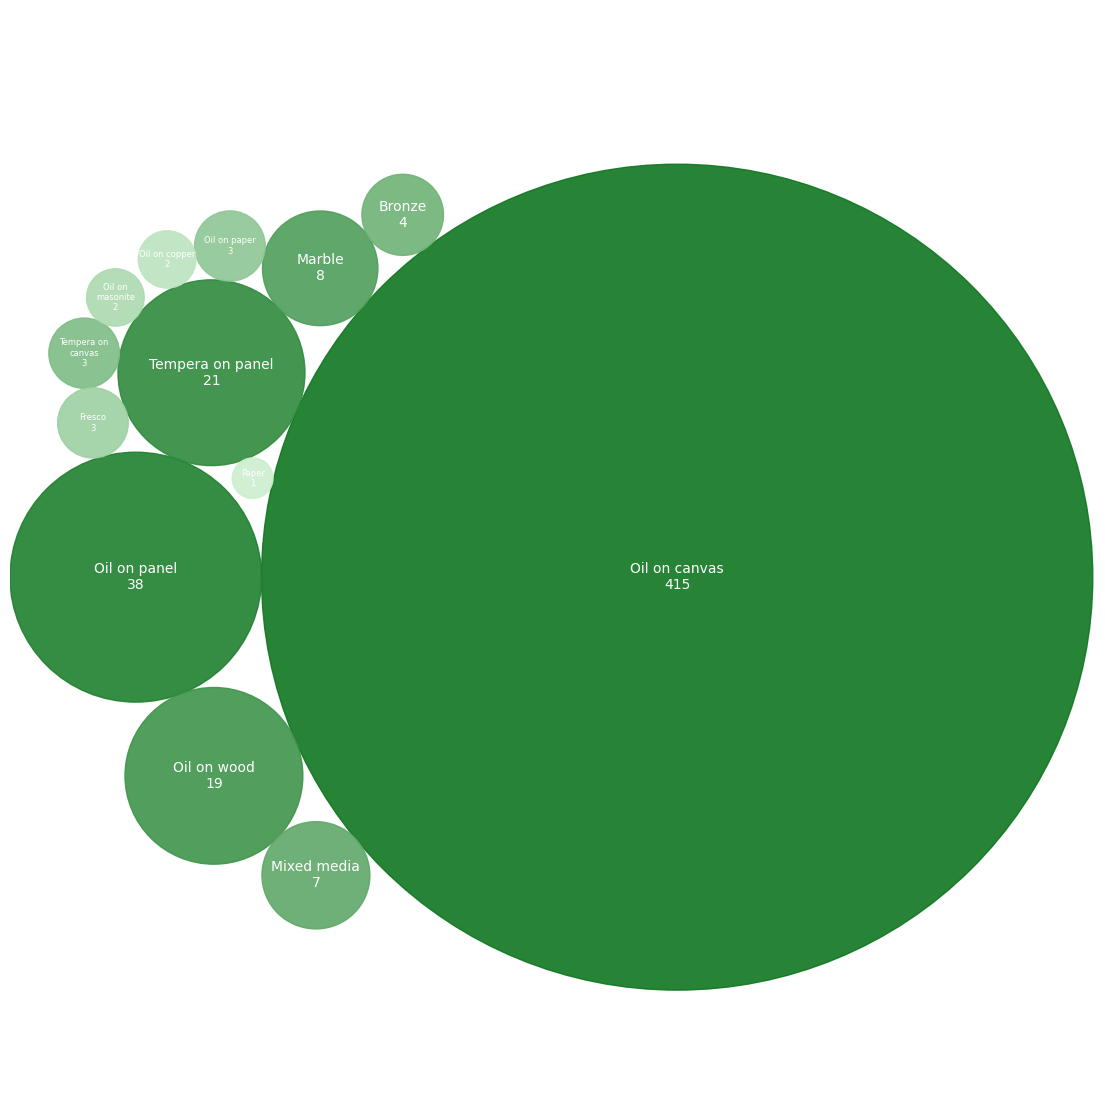

In [214]:
import circlify
# compute circle positions:
circles = circlify.circlify(medium_sum['Count'].tolist(), 
                            show_enclosure=False, 
                            target_enclosure=circlify.Circle(x=0, y=0)
                           )
circles.reverse()

fig, ax = plt.subplots(figsize=(14, 14), facecolor='white')
ax.axis('off')
lim = max(max(abs(circle.x)+circle.r, abs(circle.y)+circle.r,) for circle in circles)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

colors = get_color_gradient(color_2, color_1, len(medium_sum))
# print circles
i = 0
for circle, label, emi, color in zip(circles, medium_sum['Medium'], medium_sum['Count'], colors):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.9, color = color))
    if label == 'Tempera on canvas':
        plt.annotate("Tempera on" + '\n' + 'canvas' +'\n'+ format(emi, ","), (x,y), size=6, va='center', ha='center', color='White')
    elif label == 'Oil on masonite':
        plt.annotate("Oil on" + '\n' + 'masonite' +'\n'+ format(emi, ","), (x,y), size=6, va='center', ha='center', color='White')
    else:
        if i < 7:
            plt.annotate(label +'\n'+ format(emi, ","), (x,y), size=10, va='center', ha='center', color='White')
        else:
            plt.annotate(label +'\n'+ format(emi, ","), (x,y), size=6, va='center', ha='center', color='White')
    i = i + 1
plt.xticks([])
plt.yticks([])
plt.savefig('medium.png')